In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import admix
from tqdm import tqdm
import matplotlib
import admix_genet_cor

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
DATA_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/05-real-locus"

In [3]:
df_info = pd.DataFrame(
    [
        ["ukb", "erythrocyte", 16, 357598, "UKB RBC 16p13.3"],
        ["page", "crp", 1, 159638387, "PAGE CRP 1q23.2"],
        ["page", "hdl", 11, 116810245, "PAGE HDL 11q23.3"],
        ["ukb", "log_triglycerides", 19, 35065736, "UKB Triglycerides 19q13.11"],
        ["ukb", "MCH", 16, 1121191, "UKB MCH 16p13.3"],
    ],
    columns=["study", "trait", "chrom", "pos", "title"],
)

In [4]:
dict_susie = dict()
for _, row in df_info.iterrows():
    dict_cs = dict()
    with open(
        os.path.join(
            "out/locus-plot", f"{row.study}-{row.trait}-{row.chrom}-{row.pos}.txt"
        )
    ) as f:
        lines = [line.strip() for line in f.readlines()[1:]]
        for line in lines:
            k, v = line.split("\t")
            k = k.strip()
            v = v.strip().split(" ")
            if k.startswith("L"):
                dict_cs[k] = np.array([int(i) - 1 for i in v])
            else:
                pip = np.array([float(i) for i in v])
    dict_susie[f"{row.study}-{row.trait}"] = pip, dict_cs

In [5]:
df_info

,study,trait,chrom,pos,title
0,ukb,erythrocyte,16,357598,UKB RBC 16p13.3
1,page,crp,1,159638387,PAGE CRP 1q23.2
2,page,hdl,11,116810245,PAGE HDL 11q23.3
3,ukb,log_triglycerides,19,35065736,UKB Triglycerides 19q13.11
4,ukb,MCH,16,1121191,UKB MCH 16p13.3


In [6]:
dict_assoc = dict()
for _, row in df_info.iterrows():
    study, trait, chrom, pos, title = row

    # read association
    df_assoc = pd.read_csv(
        os.path.join(DATA_DIR, f"out/gwas-assoc/{study}-{trait}.assoc"),
        delim_whitespace=True,
    )
    df_assoc = df_assoc[
        (df_assoc["#CHROM"] == chrom)
        & (df_assoc["POS"].between(pos - 1.5e6, pos + 1.5e6))
    ]
    dict_assoc[f"{row.study}-{row.trait}"] = df_assoc

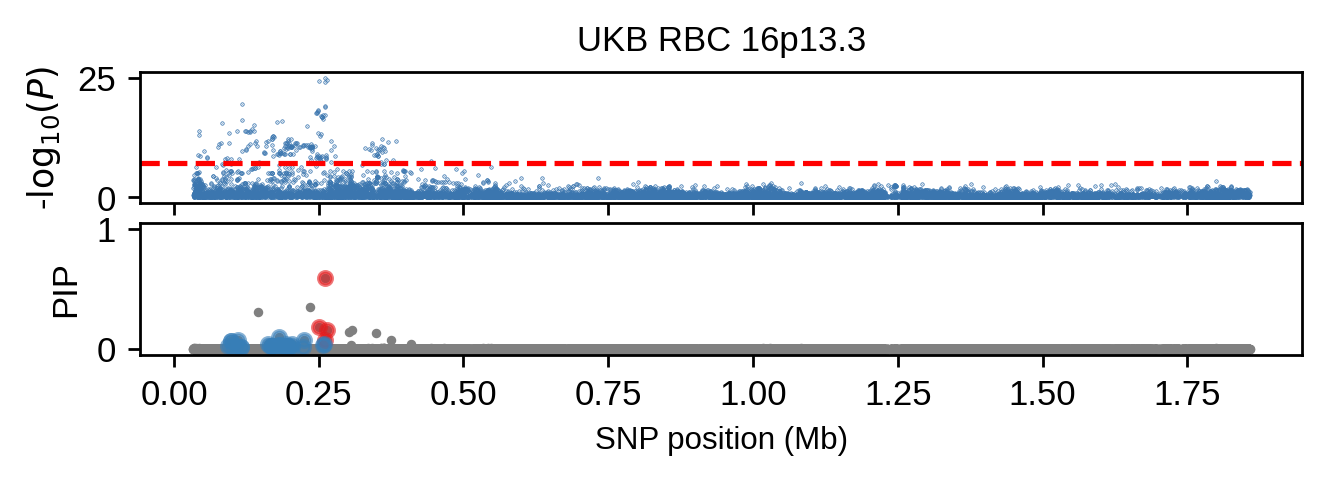

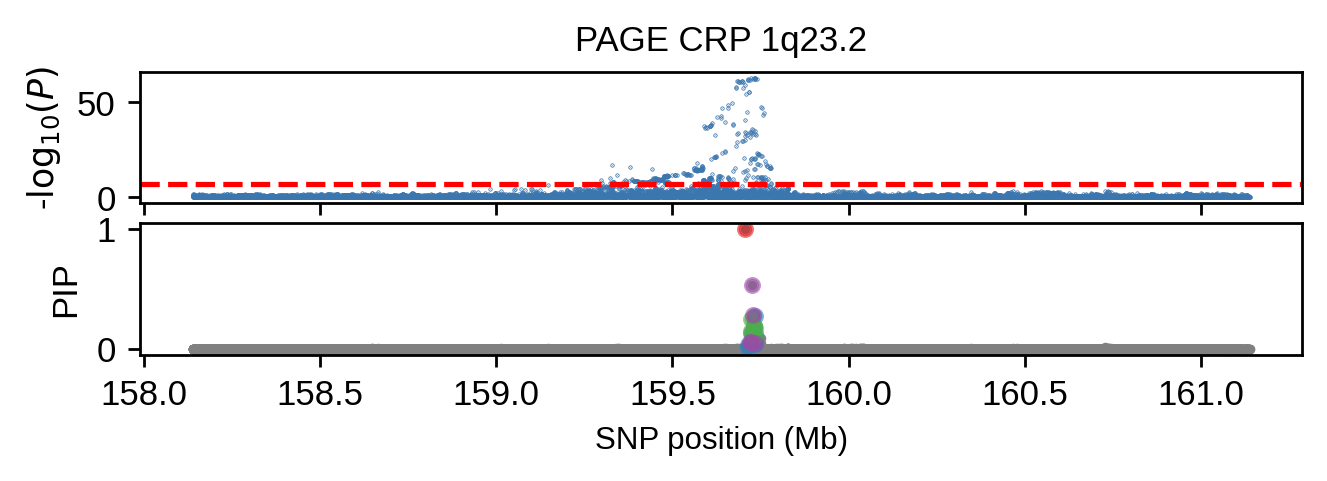

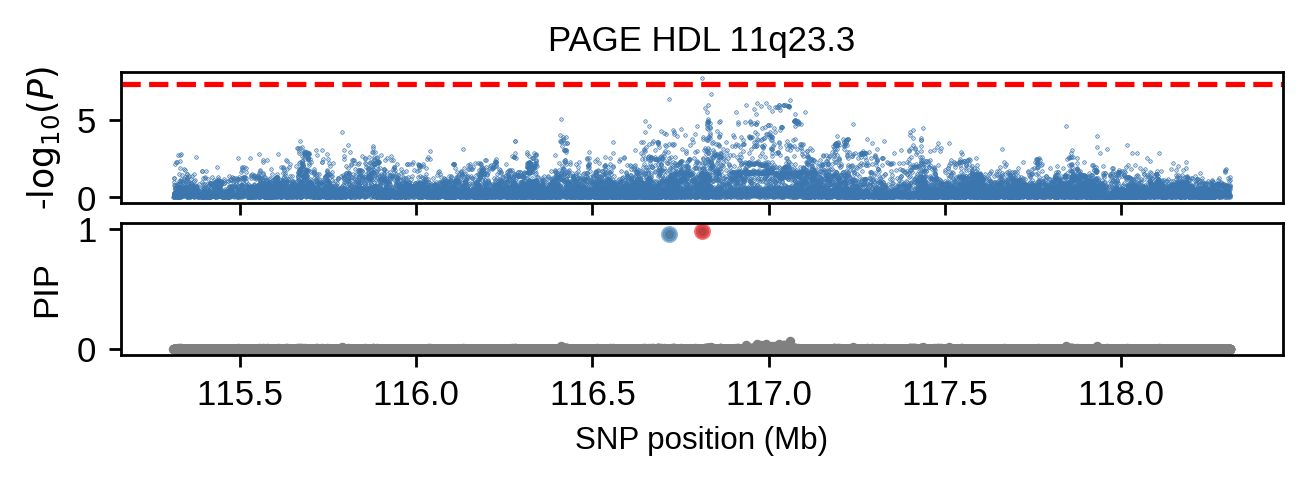

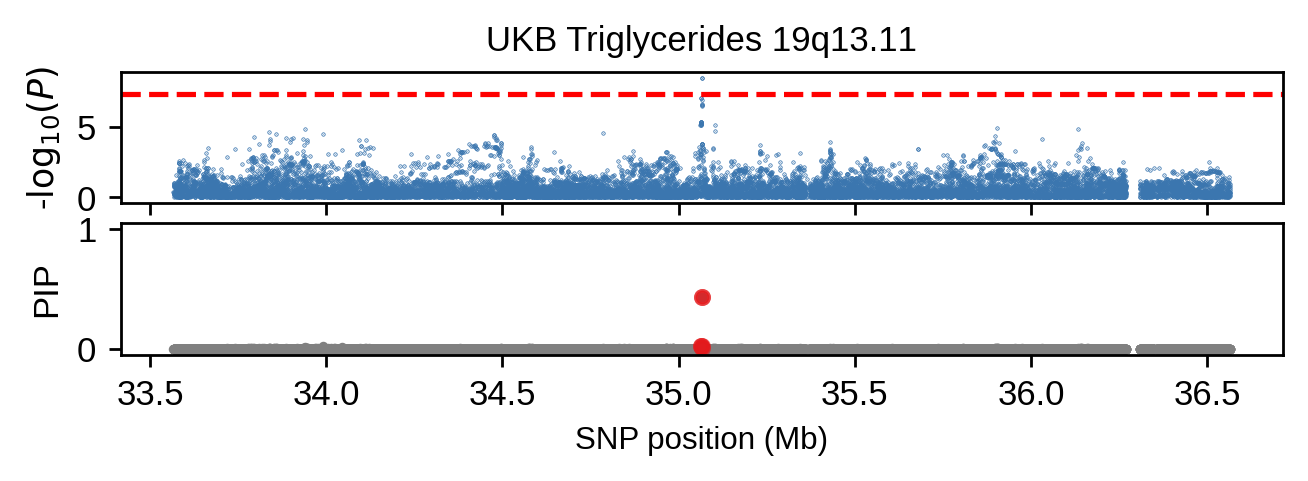

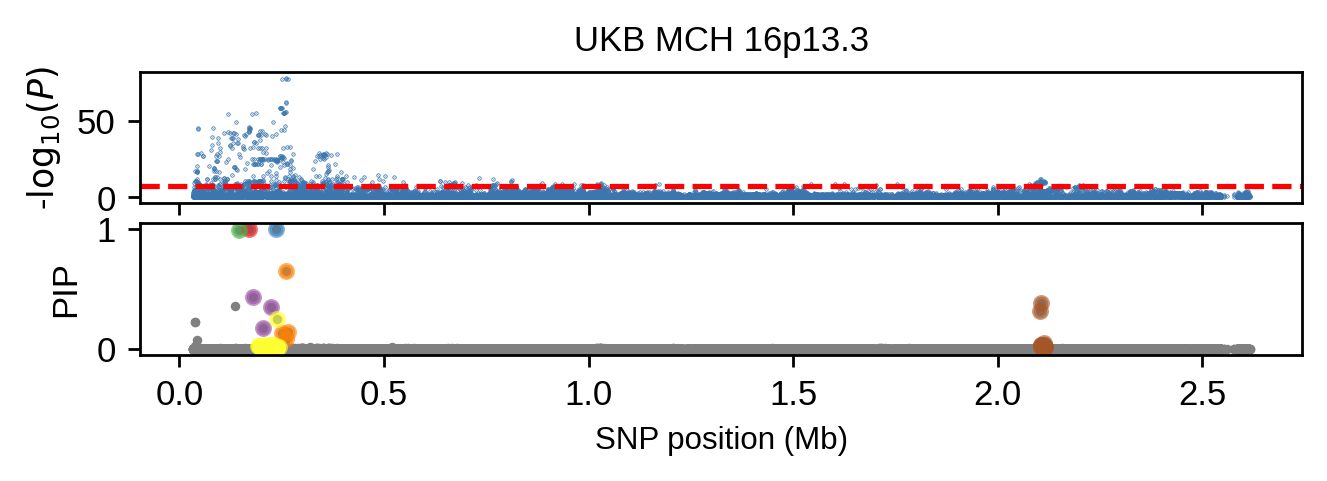

In [7]:
for _, row in df_info.iterrows():
    plot_id = f"{row.study}-{row.trait}"
    df_assoc = dict_assoc[plot_id]
    pip, dict_cs = dict_susie[plot_id]
    fig, axes = plt.subplots(figsize=(6, 1.5), dpi=250, nrows=2, sharex=True)
    admix.plot.manhattan(
        pval=df_assoc["P"], pos=df_assoc["POS"].values, s=0.05, ax=axes[0]
    )
    axes[0].set_title(row.title, fontsize=10)
    axes[0].set_xlabel(None)
    axes[1].set_xlabel(axes[1].get_xlabel(), fontsize=9)
    admix.plot.susie(pip=pip, dict_cs=dict_cs, pos=df_assoc["POS"].values, ax=axes[1])
    plt.subplots_adjust(hspace=0.15)
    fig.savefig(f"out/locus-plot/{plot_id}.png", dpi=250, bbox_inches="tight")

# Triglycerides example

In [11]:
df_sakaue = pd.read_csv("tmp-data/GCST90018975_buildGRCh37.tsv.gz", sep="\t")
df_sakaue = df_sakaue[df_sakaue.chromosome == 19].sort_values("base_pair_location")
df_sakaue = df_sakaue.rename(
    columns={"chromosome": "CHROM", "base_pair_location": "POS", "p_value": "P"}
)
df_sakaue["POS_hg38"] = admix.tools.liftover.run(
    df_sakaue[["CHROM", "POS"]], chain="hg19->hg38"
)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


745 variants were not mapped


In [27]:
row = df_info.iloc[3, :]
plot_id = f"{row.study}-{row.trait}"
df_assoc = dict_assoc[plot_id]
pip, dict_cs = dict_susie[plot_id]

print(row)

study                           ukb
trait             log_triglycerides
chrom                            19
pos                        35065736
title    UKB Triglycerides 19q13.11
Name: 3, dtype: object


In [28]:
xmin, xmax = df_assoc.POS.min(), df_assoc.POS.max()

In [29]:
dict_pval = dict()

df_tmp = df_sakaue[df_sakaue.POS_hg38.between(xmin, xmax)]
dict_pval["sakaue"] = pd.DataFrame(
    {"POS": df_tmp.POS_hg38.values, "P": df_tmp.P.values}
)
# UKB AfrEur
dict_pval["ukb_admix"] = pd.DataFrame(
    {"POS": df_assoc.POS.values, "P": df_assoc.P.values}
)

In [30]:
sakaue_lead_pos = dict_pval["sakaue"].POS[dict_pval["sakaue"].P.argmin()]
ukb_lead_pos = dict_pval["ukb_admix"].POS[dict_pval["ukb_admix"].P.argmin()]

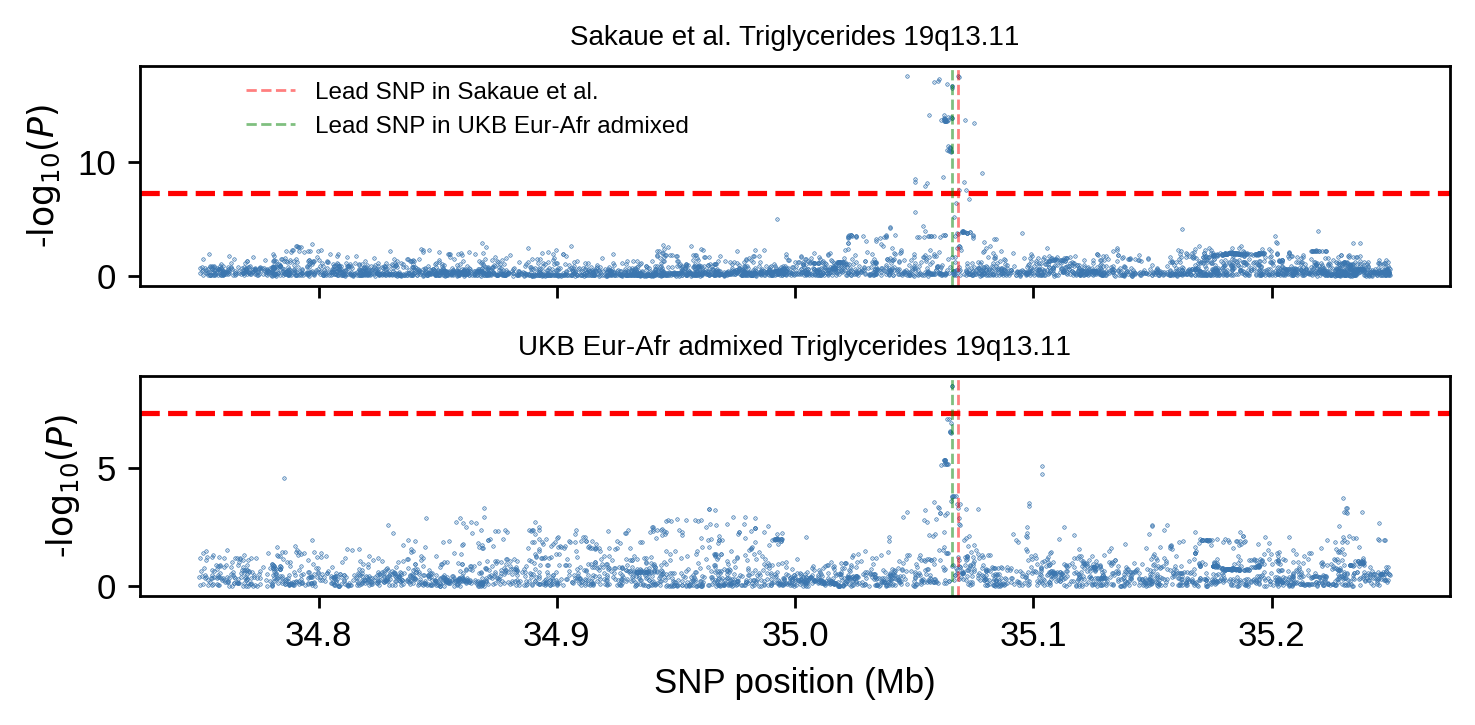

In [32]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=250, nrows=2, sharex=True)

for i, name in enumerate(dict_pval):
    df_tmp = dict_pval[name]
    df_tmp = df_tmp[df_tmp.POS.between(34.75 * 1e6, 35.25 * 1e6)]
    admix.plot.manhattan(pval=df_tmp.P, pos=df_tmp.POS, s=0.05, ax=axes[i])
    axes[i].axvline(
        x=sakaue_lead_pos / 1e6,
        label="Lead SNP in Sakaue et al.",
        ls="--",
        lw=0.8,
        alpha=0.5,
        color="red",
    )

    axes[i].axvline(
        x=ukb_lead_pos / 1e6,
        label="Lead SNP in UKB Eur-Afr admixed",
        ls="--",
        lw=0.8,
        alpha=0.5,
        color="green",
    )

axes[0].legend(bbox_to_anchor=[0.25, 0.8], loc="center", frameon=False, fontsize=7)
axes[0].set_title("Sakaue et al. Triglycerides 19q13.11", fontsize=8)
axes[1].set_title("UKB Eur-Afr admixed Triglycerides 19q13.11", fontsize=8)
axes[0].set_xlabel(None)
fig.tight_layout()
fig.savefig(f"out/locus-plot/ukb-tg-sakaue.png", dpi=250)

# Check heterogeneity p-value at other SNPs

In [13]:
UKB_GENO_DIR = "/u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed"
UKB_PHENO_DIR = "/u/project/sgss/UKBB/UKB-ADMIXED/02-genet-cor/out/pheno/"

In [14]:
study = "ukb"
trait = "log_triglycerides"
chrom = 19

In [15]:
# load both phenotype and covariates
geno_dir = UKB_GENO_DIR
pheno_dir = UKB_PHENO_DIR

pheno_path = os.path.join(pheno_dir, f"{trait}-sample10pc.tsv")
df_sample_info = pd.read_csv(pheno_path, sep="\t", index_col=0, low_memory=False)

pheno_col = df_sample_info.columns[0]
covar_cols = df_sample_info.columns[1:]

# format phenotype and covariates
df_trait = pd.read_csv(pheno_path, sep="\t", index_col=0)
df_trait.index = df_trait.index.astype(str)

dset = admix.io.read_dataset(
    os.path.join(geno_dir, "chr1"),
    n_anc=2,
)
for col in dset._indiv:
    dset._indiv.drop(columns=col, inplace=True)

# subset for individuals with non-nan value in df_trait
dset = dset[:, dset.indiv.index.isin(df_trait.index)]
dset.append_indiv_info(df_trait)
pheno_col = df_trait.columns[[0]]
covar_cols = df_trait.columns[1:]

df_pheno = dset.indiv[pheno_col].copy()
df_covar = dset.indiv[covar_cols].copy()
df_covar = admix.data.convert_dummy(df_covar)

for col in df_pheno.columns:
    df_pheno[col] = admix.data.quantile_normalize(df_pheno[col])

for col in df_covar.columns:
    df_covar[col] = admix.data.quantile_normalize(df_covar[col])

# fill na with column mean
df_covar.fillna(df_covar.mean(), inplace=True)

2022-04-07 20:07.01 [info     ] admix.Dataset: read local ancestry from /u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/chr1.lanc
2022-04-07 20:07.06 [info     ] Detected categorical columns: 
2022-04-07 20:07.06 [info     ] Added dummy variables: 


In [20]:
# subset dset
dset = admix.io.read_dataset(
    os.path.join(geno_dir, f"chr{chrom}"),
    n_anc=2,
)
dset = dset[
    (dset.snp.POS.isin([sakaue_lead_pos, ukb_lead_pos])).values,
    df_pheno.index.values,
]
dset.persist()

apa = dset.allele_per_anc()
af = dset.af_per_anc()

for snp_i in tqdm(range(dset.n_snp)):
    p_het, model_het = admix_genet_cor.test_snp_het(
        apa[snp_i, :, :], df_pheno.values, df_covar.values
    )
    p_assoc, model_assoc = admix_genet_cor.test_snp_assoc(
        apa[snp_i, :, :], df_pheno.values, df_covar.values
    )
    print(snp_i, p_het, p_assoc)

2022-04-07 20:07.36 [info     ] admix.Dataset: read local ancestry from /u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/chr19.lanc


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]

0 0.0003349465701421519 3.45313564171575e-09
1 0.6074386496489418 0.0004855286305635191
